In [1]:
# -*- coding: utf-8 -*-

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score
from sklearn.metrics import auc as calculate_auc

import matplotlib.pyplot as plt
import seaborn as sns

from aggmap import AggMap, AggMapNet, loadmap

np.random.seed(666)

def prc_auc_score (y_true, y_score):
    precision, recall, threshold = precision_recall_curve(y_true, y_score) # PRC_AUC
    auc = calculate_auc(recall, precision)
    return auc

In [3]:
import tensorflow as tf
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
physical_gpus = tf.config.experimental.list_physical_devices('GPU') 
print("physical_gpus:")
print(physical_gpus)
tf.config.experimental.set_memory_growth(physical_gpus[0], True)

physical_gpus:
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2022-12-21 15:40:41.881554: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-12-21 15:40:41.968865: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:07:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-12-21 15:40:41.968921: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-12-21 15:40:41.973365: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-12-21 15:40:41.973441: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2022-12-21 15:40:41.974887: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.

In [2]:
dataset = './dataset/dataset_1647_all.csv'
data_df = pd.read_csv(dataset)
dfx = data_df[data_df.columns[1:-42]]
dfy = data_df[data_df.columns[-42:]]   # 取列用list，得到的对象才是DataFrame

In [3]:
print(dfx.shape)
print(dfy.shape)

(8272, 1647)
(8272, 42)


In [7]:
# alkane, methyl, alkene, alkyne, alcohols, 
# amines, nitriles, aromatics, alkyl halides, esters, 
# ketones, aldehydes, carboxylic acids, ether, acyl halides, amides, nitro

func_grp = '-N=C=O'
X = dfx.values
Y = pd.get_dummies(dfy[func_grp]).values.astype(float)

In [8]:
channels = 10
#mp = AggMap(dfx, metric='correlation')
#mp.fit(cluster_channels=channels, verbose=0)
#mp.save('./model/1647_IR_aggmap_correlation_c{}.mp'.format(channels))
mp = loadmap('./model/1647_IR_aggmap_correlation_c{}.mp'.format(channels))

In [10]:
results = []
results_num = []

for random_seed in [8, 32, 128]:   # 随机种子用于划分数据集
    outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)
    fold_idx = 0
    
    for train_idx, test_idx in outer.split(X, Y[:, 1]): # X是数据，Y是一维标签，X和Y的数量要一致
        train_X, test_X = X[train_idx], X[test_idx]
        trainY, testY = Y[train_idx], Y[test_idx]
        
        trainX = mp.batch_transform(train_X, scale_method='standard')
        testX = mp.batch_transform(test_X, scale_method='standard')
        print("trainX shape is: " + str(trainX.shape))
        print("testX shape is: " + str(testX.shape))
        
        clf = AggMapNet.MultiClassEstimator(epochs=80, batch_size=4, dense_layers=[256, 128], dropout=0.5)
        clf.fit(trainX, trainY)
        
        y_true = testY[:, 1] # 标签与outer.split一致
        y_pred = clf.predict(testX)
        y_score = clf.predict_proba(testX)[:, 1]
        
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        
        acc = (tp + tn) / sum([tn, fp, fn, tp])
        sensitivity = tp / sum([tp, fn])
        specificity = tn / sum([tn, fp])
        
        prc_auc = prc_auc_score(y_true, y_score)
        roc_auc = roc_auc_score(y_true, y_score)
        
        precision = tp / sum([tp, fp])
        recall = sensitivity
        F1 = 2 * precision * sensitivity / (precision + sensitivity)
        
        # res 记录结果用来画图
        res = clf.history   # dictionary
        res['fold'] = fold_idx
        res['channel'] = channels
        res['random_seed'] = random_seed
        
        # res_num 记录结果用来看数值
        fold_num = "fold_%s" % str(fold_idx).zfill(2)
        res_num = {'fold': fold_num,
              'random_seed': random_seed,
              'accuracy': acc,
              'prc_auc': prc_auc,
              'roc_auc': roc_auc,
              'sensitivity': sensitivity,
              'specificity': specificity,
              'precision': precision,
              'recall': recall,
              'F1': F1}
        
        results.append(res)
        results_num.append(res_num)
        fold_idx += 1
        break
        

100%|###########################################################################################| 1655/1655 [00:25<00:00, 64.36it/s]


trainX shape is: (6618, 41, 41, 10)
testX shape is: (1655, 41, 41, 10)
MultiClassEstimator(batch_norm=False, batch_size=4, conv1_kernel_size=13,
                    dense_avf='relu', dense_layers=[256, 128], dropout=0.5,
                    epochs=100, gpuid='0', last_avf='softmax',
                    loss='categorical_crossentropy', lr=0.0001, metric='ACC',
                    monitor='val_loss', n_inception=2,
                    name='AggMap MultiClass Estimator', patience=10000,
                    random_state=32, verbose=0)


100%|##########################################################################################| 1655/1655 [00:13<00:00, 123.82it/s]


trainX shape is: (6618, 41, 41, 10)
testX shape is: (1655, 41, 41, 10)
MultiClassEstimator(batch_norm=False, batch_size=4, conv1_kernel_size=13,
                    dense_avf='relu', dense_layers=[256, 128], dropout=0.5,
                    epochs=100, gpuid='0', last_avf='softmax',
                    loss='categorical_crossentropy', lr=0.0001, metric='ACC',
                    monitor='val_loss', n_inception=2,
                    name='AggMap MultiClass Estimator', patience=10000,
                    random_state=32, verbose=0)


100%|##########################################################################################| 1655/1655 [00:12<00:00, 134.19it/s]


trainX shape is: (6618, 41, 41, 10)
testX shape is: (1655, 41, 41, 10)
MultiClassEstimator(batch_norm=False, batch_size=4, conv1_kernel_size=13,
                    dense_avf='relu', dense_layers=[256, 128], dropout=0.5,
                    epochs=100, gpuid='0', last_avf='softmax',
                    loss='categorical_crossentropy', lr=0.0001, metric='ACC',
                    monitor='val_loss', n_inception=2,
                    name='AggMap MultiClass Estimator', patience=10000,
                    random_state=32, verbose=0)


In [ ]:
confusion_matrix(y_true, y_pred)

array([[1623,    0],
       [  32,    0]])

In [11]:
res_df = pd.DataFrame(results)
# res_df.to_csv('./result/2Class_1647_{}_valid.csv'.format(func_grp))
res_df

,loss,val_loss,accuracy,val_accuracy,epoch,fold,channel,random_seed
0,"[0.0998278558254242, 0.06594415009021759, 0.05...","[0.06462551653385162, 0.046985846012830734, 0....","[0.9808099123602296, 0.9808099123602296, 0.981...","[0.9808099123602296, 0.9808099123602296, 0.981...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0,10,8
1,"[0.09570292383432388, 0.07024102658033371, 0.0...","[0.06960955262184143, 0.053625769913196564, 0....","[0.9808099123602296, 0.9844363856149895, 0.982...","[0.9808099123602296, 0.9844363856149895, 0.982...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0,10,32
2,"[0.09368641674518585, 0.07208102196455002, 0.0...","[0.0641154795885086, 0.05312687158584595, 0.04...","[0.9808099123602296, 0.9808099123602296, 0.981...","[0.9808099123602296, 0.9808099123602296, 0.981...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0,10,128


In [12]:
res_num_df = pd.DataFrame(results_num)
# res_num_df.to_csv('./result/2Class_1647_{}_test.csv'.format(func_grp))
res_num_df

,fold,random_seed,accuracy,prc_auc,roc_auc,sensitivity,specificity,precision,recall,F1
0,fold_00,8,0.989124,0.712141,0.965881,0.65625,0.995687,0.750000,0.65625,0.700000
1,fold_00,32,0.987915,0.693537,0.964042,0.59375,0.995687,0.730769,0.59375,0.655172
2,fold_00,128,0.987311,0.790377,0.984731,0.59375,0.995071,0.703704,0.59375,0.644068


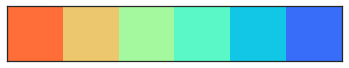

In [14]:
color = sns.color_palette("rainbow_r", 6) #PiYG
sns.palplot(color)

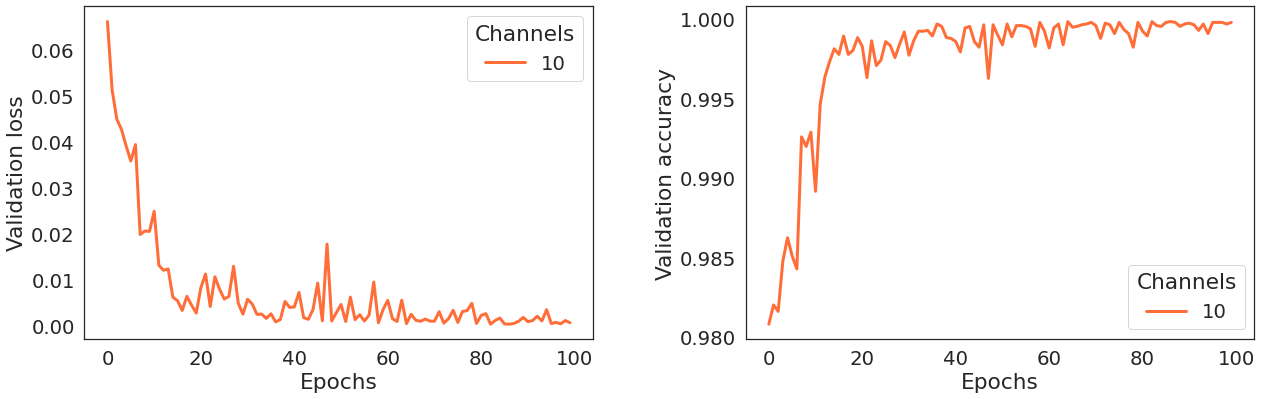

In [15]:
sns.set(style = 'white', font_scale=1.8)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,6), sharex=False, sharey=False)
ax1, ax2 = axes        


col = 'val_loss'
loss_mean = res_df.groupby(['channel']).agg({col: lambda x:x.tolist()})[col].apply(lambda x: np.array(x).mean(axis=0)).apply(pd.Series).T
loss_std = res_df.groupby(['channel']).agg({col: lambda x:x.tolist()})[col].apply(lambda x: np.array(x).std(axis=0)).apply(pd.Series).T

loss_mean.columns.name = 'Channels'
loss_std.columns.name = 'Channels'

loss_mean.plot(ax=ax1, lw=3, color=color)
ax1.set_ylabel('Validation loss')
ax1.set_xlabel('Epochs')

col = 'val_accuracy'
acc_mean = res_df.groupby(['channel']).agg({col: lambda x:x.tolist()})[col].apply(lambda x: np.array(x).mean(axis=0)).apply(pd.Series).T
acc_std = res_df.groupby(['channel']).agg({col: lambda x:x.tolist()})[col].apply(lambda x: np.array(x).std(axis=0)).apply(pd.Series).T


acc_mean.columns.name = 'Channels'
acc_std.columns.name = 'Channels'

acc_mean.plot(ax=ax2, lw=3, color=color)
ax2.set_ylabel('Validation accuracy')
ax2.set_xlabel('Epochs')

fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3)
# plt.savefig('./result/450_%s_5FCV_correlation_valid.png' % func_grp, bbox_inches='tight', dpi=400)

In [ ]:
res_num_df.groupby('random_seed').apply(np.mean).mean().round(3)  # 均值

In [ ]:
res_num_df.groupby('random_seed').apply(np.std).mean().round(3)  # 标准差